In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from fkan.torch import FractionalJacobiNeuralBlock as fJNB
from torch import optim

If using a predefined Keras activation function, comment out `act = fJNB(q)` and uncomment `act = nn.Activation()`, specifying your desired activation function.

In [2]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.jacobies = []
        self.hiddens = []
        for i in range(1, 7):
            act = fJNB(i)
            # act = nn.Tanh()
            self.jacobies.append(act)
            self.hiddens.append(nn.Linear(1, 10))
        self.output = nn.Linear(10 * len(self.jacobies), 1)

    def forward(self, x):
        acts = []
        for hidden, jacobi in zip(self.hiddens, self.jacobies):
            q = hidden(x)
            acts.append(jacobi(q))
        h = torch.cat(acts, dim=1)
        output = self.output(h)
        return output

In [3]:
def dy_dx(y, x):
    return torch.autograd.grad(
        y, x, grad_outputs=torch.ones_like(y), create_graph=True
    )[0]

In [4]:
def closure():
    loss = get_loss(x)
    optimizer.zero_grad()
    loss.backward()
    return loss

In [5]:
def get_loss(x):
    global m
    y = mlp.forward(x)
    y_x = dy_dx(y, x)
    y_xx = dy_dx(y_x, x)
    residual = x * y_xx + 2 * y_x + x * y**m
    initial1 = y[0] - 1  # float
    initial2 = y_x[0] - 0  # float

    loss = 1e5 * ((residual**2).mean() + initial1**2 + initial2**2)
    return loss

In [6]:
def get_score(mlp, start, end, root_state_of_the_art):
    x_test = torch.linspace(start, end, 100000)[1:].reshape(-1, 1)
    predict = mlp.forward(x_test).detach()
    indx_root = torch.argmin(torch.abs(predict))
    return x_test[indx_root].item() - root_state_of_the_art


params_for_m = [
    {"start": 2, "end": 3, "root_state_of_the_art": 2.44948974},
    {"start": 3, "end": 4, "root_state_of_the_art": 3.14159265},
    {"start": 4, "end": 5, "root_state_of_the_art": 4.35287460},
    {"start": 6, "end": 7, "root_state_of_the_art": 6.8968486},
    {"start": 14, "end": 15, "root_state_of_the_art": 14.9715463},
]

In [7]:
m = 2
score_params = params_for_m[m]

x = torch.linspace(0, score_params["end"], 1501, requires_grad=True).reshape(-1, 1)

mlp = Model()
optimizer = optim.LBFGS(list(mlp.parameters()), lr=0.1)

In [8]:
losses = []
scores = []
for i in range(50):
    loss = get_loss(x)
    optimizer.step(closure)
    losses.append(loss.detach().numpy())
    scores.append(get_score(mlp, **score_params))
    if i % 2 == 0:
        print(
            "Epoch %3d: Current loss: %.2e, Error Predicted Root: %.2e"
            % (i, losses[-1], scores[-1])
        )

Epoch   0: Current loss: 2.41e+05, Error Predicted Root: 2.79e-01
Epoch   2: Current loss: 1.15e+02, Error Predicted Root: -2.48e-02
Epoch   4: Current loss: 1.06e+00, Error Predicted Root: -2.06e-03
Epoch   6: Current loss: 3.95e-01, Error Predicted Root: 6.09e-04
Epoch   8: Current loss: 8.29e-02, Error Predicted Root: 2.88e-05
Epoch  10: Current loss: 7.34e-02, Error Predicted Root: -1.07e-03
Epoch  12: Current loss: 3.95e-02, Error Predicted Root: -1.61e-03
Epoch  14: Current loss: 2.67e-02, Error Predicted Root: -5.11e-04
Epoch  16: Current loss: 2.19e-02, Error Predicted Root: -2.61e-04
Epoch  18: Current loss: 1.83e-01, Error Predicted Root: 4.39e-04


In [9]:
print("best score: %.2e" % min(scores, key=abs))

best score: 8.74e-06


In [10]:
# torch.save(mlp,'jnb-m-%d.pt' % m)

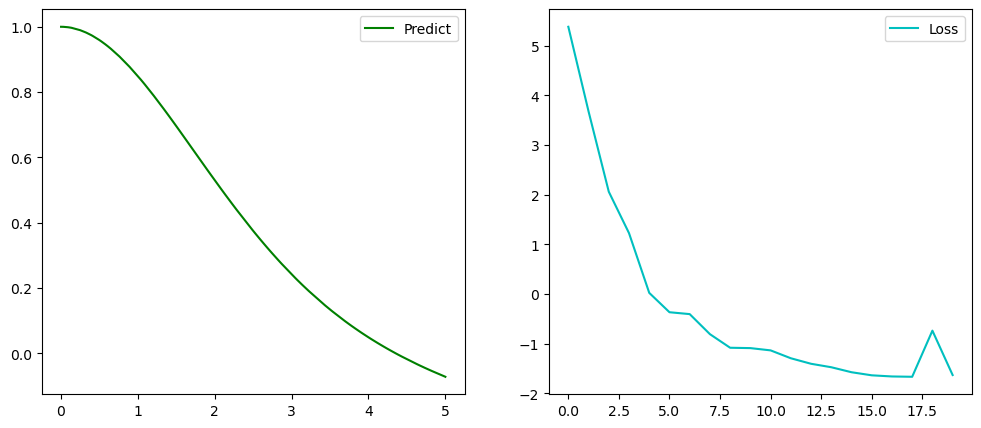

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

x_test = torch.linspace(0, x[-1, 0], 10000)[1:].reshape(-1, 1)

predict = mlp.forward(x_test).detach().numpy()
np.save("m-%d.npy" % m, predict)

axs[0].plot(x_test, predict, "g-", label="Predict")

axs[1].plot(np.log10(losses), "c", label="Loss")

for ax in axs:
    ax.legend()